In [1]:
#dependencies
import pandas as pd
import numpy as np
from dateutil import parser
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt

Using TensorFlow backend.


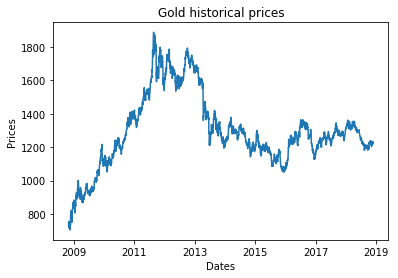

In [22]:
filename = "Gold Futures Historical Data.csv"
data = pd.read_csv(filename)
prices = [float(price.replace(",","")) for price in data['Price']]
prices = prices[::-1]
dates = [parser.parse(dt) for dt in data['Date']][::-1]
plt.plot(dates,prices)
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.title("Gold historical prices")
plt.show()

For making predictions on future prices we use a technique called rolling regression. For this we require a window size which determines the number of past values used to predict a future value. The following function in the cell below creates the dataset for rolling regression when provided with the price data and window sizes as parameters. 

In [3]:
#create dataset for rolling regression
def create_dataset(data,window_size):
    X,y = [],[]
    for i in range(0,len(data)-window_size-1):
        x = data[i:i+window_size]
        X.append(x)
        y.append(data[i+window_size])
    return np.array(X),np.array(y)

In [4]:
def train_test_split(data,train_size):
    train_size = int(train_size*len(data))
    train, test = data[:train_size], data[train_size:]
    return train, test

The window size is a variable that needs to be determined for optimal performance. For that we take a range of window sizes and over a mini data set(which is a part of the actual data), we perform rolling regression and hence save the Rsquared scores.
We choose the window size with the highest score. The following few cells help us to determine the optimal window size.
The plot below shows the scores plot with different window sizes. 

In [5]:
window_sizes = [i for i in range(1,50)]
sample_data = np.array(prices[:200]).reshape(-1,1)
scaler = MinMaxScaler()
sample_data = scaler.fit_transform(sample_data)
sample_data = sample_data.ravel()
scores = []

for window_size in window_sizes:
    X,y = create_dataset(sample_data,window_size)
    trainX, testX = train_test_split(X,0.8)
    trainy, testy = train_test_split(y,0.8)
    model = linear_model.LinearRegression()
    score = model.fit(trainX, trainy).score(testX,testy)
    scores.append(score)


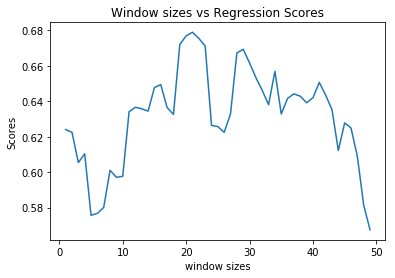

In [14]:
plt.plot(window_sizes,scores)
plt.xlabel("window sizes")
plt.ylabel("Scores")
plt.title("Window sizes vs Regression Scores")
plt.show()

In [7]:
optimal_window = scores.index(max(scores))+1
print(optimal_window)

21


The following cell uses the entire price data to create rolling regression window sizes of 21 and also split the entire dataset into train and test sets. The data is normalized in a scale of 0 to 1 for better convergence and hence fed through a linear regression model. Since the idea is to check only if prediction is possible, no hyperparameter tuning or model selection has been done. The default setting of the regressor has been used here.
The Test data is used to predict future prices and hence the predictions and the true values are plotted(a display range i.e number of data points is chosen for better clarity).
The plot shows that predictions can be made, although not absolutely accurate but it is possible to identify the movement direction correctly.

In [8]:
data = np.array(prices).reshape(-1,1)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = data.ravel()
X,y = create_dataset(data,optimal_window)
trainX, testX = train_test_split(X,0.8)
trainy, testy = train_test_split(y,0.8)
model = linear_model.LinearRegression()
fit = model.fit(trainX, trainy)
predicts= fit.predict(testX)
predicts = scaler.inverse_transform(predicts.reshape(-1,1))
trues = scaler.inverse_transform(testy.reshape(-1,1))

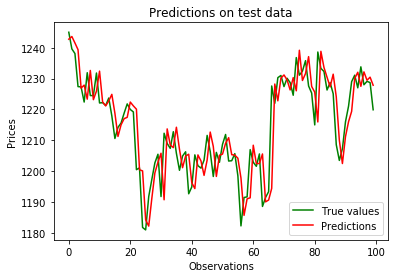

In [23]:
display_size = 100
plt.plot(trues[-display_size:],'green',label = 'True values')
plt.plot(predicts[-display_size:],'red',label = 'Predictions')
plt.xlabel("Observations")
plt.ylabel("Prices")
plt.title("Predictions on test data")
plt.legend(loc = 'lower right')
plt.show()

In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(np.shape(trainX), np.shape(trainy))

(2066, 1, 21) (2066,)


In [11]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, optimal_window)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainy, epochs=10, batch_size=1, verbose=2,
          validation_data = (testX, testy))

Train on 2066 samples, validate on 517 samples
Epoch 1/10
 - 26s - loss: 0.0098 - val_loss: 4.1867e-04
Epoch 2/10
 - 16s - loss: 9.3847e-04 - val_loss: 3.5435e-04
Epoch 3/10
 - 16s - loss: 6.8151e-04 - val_loss: 2.9545e-04
Epoch 4/10
 - 17s - loss: 5.4673e-04 - val_loss: 1.4673e-04
Epoch 5/10
 - 17s - loss: 4.7835e-04 - val_loss: 2.7362e-04
Epoch 6/10
 - 17s - loss: 4.4765e-04 - val_loss: 1.6967e-04
Epoch 7/10
 - 16s - loss: 4.2260e-04 - val_loss: 1.4490e-04
Epoch 8/10
 - 20s - loss: 4.0732e-04 - val_loss: 9.7269e-05
Epoch 9/10
 - 20s - loss: 3.8464e-04 - val_loss: 3.1286e-04
Epoch 10/10
 - 17s - loss: 3.8346e-04 - val_loss: 8.4013e-05


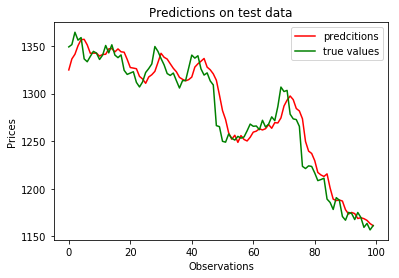

In [21]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trueTrains = scaler.inverse_transform(trainy.ravel().reshape(-1,1))
trueTests = scaler.inverse_transform(testy.ravel().reshape(-1,1))

plt.plot(trainPredict[-100:], color = "red", label = 'predcitions')
plt.plot(trueTrains[-100:], color = "green", label = 'true values')
plt.xlabel("Observations")
plt.ylabel("Prices")
plt.title("Predictions on train data")
plt.legend(loc = 'upper right')
plt.show()

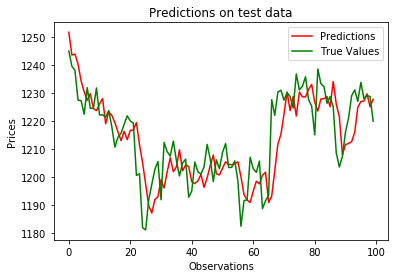

In [25]:
plt.plot(testPredict[-100:], color = "red", label = "Predictions")
plt.plot(trueTests[-100:], color = "green", label = "True Values")
plt.xlabel("Observations")
plt.ylabel("Prices")
plt.title("Predictions on test data")
plt.legend(loc = 'upper right')
plt.show()